<a href="https://colab.research.google.com/github/Benteaux/karpathy-tutorials/blob/main/notebooks/makemore3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# makemore 3!

In [ ]:
import torch
import matplotlib.pyplot as plt
names = open("names.txt", "r").read().splitlines()

In [ ]:
len(names)

32033

In [ ]:
alphabet = sorted(list(set('.'.join(names))))
stoi = {s:i for i, s in enumerate(alphabet)}
itos = {i:s for s, i in stoi.items()}

In [ ]:
X, Y = [], []
block = 3 # size of context window
for name in names:
  context = [0] * block
  for char in name + '.':
    ix = stoi[char]
    X.append(context)
    Y.append(ix)
    context = context[1:] + [ix]


In [ ]:
x = torch.tensor(X)
y = torch.tensor(Y)

In [ ]:
x, y

(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 13],
         ...,
         [26, 26, 25],
         [26, 25, 26],
         [25, 26, 24]]),
 tensor([ 5, 13, 13,  ..., 26, 24,  0]))

In [ ]:
block = 3
def build_dataset(data):
  x = []
  y = []
  for name in data:
    context = [0] * block
    for char in name + '.':
      ix = stoi[char]
      x.append(context)
      y.append(ix)
      context = context[1:] + [ix]

  x = torch.tensor(x)
  y = torch.tensor(y)
  print(f'{x.shape}, {y.shape}')
  return x, y

import random
random.seed(1)
random.shuffle(names)
length = len(names)
n1 = int((0.8 * length))
n2 = int((0.9 * length))

xtr, ytr = build_dataset(names[:n1])
xdev, ydev = build_dataset(names[n1:n2])
xte, yte = build_dataset(names[n2:])

torch.Size([182254, 3]), torch.Size([182254])
torch.Size([22914, 3]), torch.Size([22914])
torch.Size([22978, 3]), torch.Size([22978])


In [ ]:

g = torch.Generator().manual_seed(1)
# create a table
em_dim = 50
n_hidden = 300
vocab_size = 27
C = torch.randn((vocab_size, em_dim), generator = g) # for each letter we want a row with x embedding values
W1 = torch.randn((em_dim * block, n_hidden), generator = g) * 0.01 #(5/3) / ((em_dim * block) ** 0.5)
# b1 = torch.randn(n_hidden, generator = g) * 0.1 # kaparthy says having it slightly greater than 0 has helped with training
W2 = torch.randn((n_hidden, vocab_size), generator = g) * 0.01
b2 = torch.randn(vocab_size, generator = g) * 0

batchScale = torch.ones((1, n_hidden))
batchBias = torch.zeros((1, n_hidden))
batchmean_running = torch.zeros((1, n_hidden))
batchstd_running = torch.ones((1, n_hidden))
parameters = (C, W1, W2, b2, batchScale, batchBias)

In [ ]:
sum(p.nelement() for p in parameters)

55077

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
xtr.shape, ytr.shape

(torch.Size([182254, 3]), torch.Size([182254]))

In [ ]:
# lre = torch.linspace(-3, 0, 1000)
# lrs = 10**lre

In [ ]:

lri = []
losses = []
stepi = []
for i in range(100000):
  # forward pass
  ix = torch.randint(0, xtr.shape[0], (32,))
  emb = C[xtr[ix]]
  # batch norm
  hpreact = emb.view(-1, em_dim * block) @ W1
  bmeani = hpreact.mean(0, keepdims= True)
  bstdi = hpreact.std(0, keepdims = True)
  hpreact = batchScale * (hpreact - bmeani) / (bstdi + 1e-5) + batchBias
  with torch.no_grad():
    batchmean_running = 0.999 * batchmean_running + 0.01 * bmeani
    batchstd_running = 0.999 + batchstd_running + 0.01 * bstdi

  #print(loss.item())
  # nonlinearity
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = torch.nn.functional.cross_entropy(logits, ytr[ix])


  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # optimization
  lr = 0.1 if i < 70000 else 0.01 if i < 90000 else 0.001
  for p in parameters:
    p.data += -lr * p.grad
  #lri.append(lrs[i])
  stepi.append(i)
  losses.append(loss.log10().item())

In [ ]:
loss.item()

2.665543794631958

In [ ]:
loss.item()

2.1040196418762207

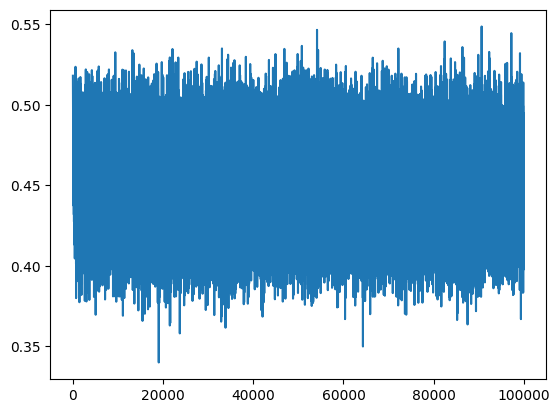

In [ ]:
plt.plot(stepi, losses)

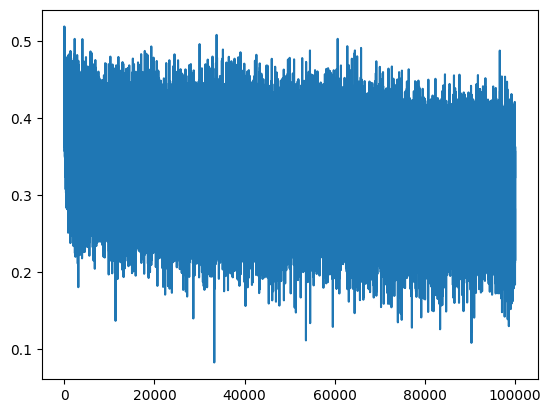

In [ ]:
plt.plot(stepi, losses)

In [ ]:
# loss on train set
@torch.no_grad()
def eval_loss(group):
  x, y = {
      'train': (xtr, ytr),
      'val': (xdev, ydev),
      'test': (xte, yte)
  }[group]
  emb = C[x]
  hpreact = emb.view(-1, block * em_dim) @ W1
  hpreact = batchScale * (hpreact - batchmean_running) / (batchstd_running + 1e-5) + batchBias
  h = torch.tanh(hpreact)
  print(h)
  logits = h @ W2 + b2
  loss = torch.nn.functional.cross_entropy(logits, y)
  return (group, loss.item())
eval_loss('train'), eval_loss('val')

tensor([[-0.0941, -0.0493, -0.2371,  ...,  0.1508,  0.1098,  0.3114],
        [-0.0941, -0.0493, -0.2372,  ...,  0.1508,  0.1098,  0.3114],
        [-0.0941, -0.0493, -0.2371,  ...,  0.1508,  0.1098,  0.3114],
        ...,
        [-0.0940, -0.0493, -0.2371,  ...,  0.1508,  0.1098,  0.3114],
        [-0.0941, -0.0493, -0.2371,  ...,  0.1509,  0.1098,  0.3114],
        [-0.0941, -0.0493, -0.2371,  ...,  0.1509,  0.1098,  0.3114]])
tensor([[-0.0941, -0.0493, -0.2371,  ...,  0.1508,  0.1098,  0.3114],
        [-0.0941, -0.0493, -0.2371,  ...,  0.1509,  0.1098,  0.3114],
        [-0.0941, -0.0493, -0.2372,  ...,  0.1509,  0.1098,  0.3114],
        ...,
        [-0.0941, -0.0493, -0.2372,  ...,  0.1508,  0.1098,  0.3114],
        [-0.0940, -0.0493, -0.2372,  ...,  0.1509,  0.1098,  0.3114],
        [-0.0941, -0.0493, -0.2371,  ...,  0.1508,  0.1098,  0.3114]])


(('train', 2.8932056427001953), ('val', 2.8947739601135254))

In [ ]:
W1.grad.sum() # .sum() is also 0

tensor(-1.0332)

In [ ]:
W2.grad.sum()

tensor(1.7881e-07)

In [ ]:
b2.grad.sum() # .sum() is also a small number

tensor(-2.2352e-08)

In [ ]:
# WHEN THE WEIGHTS AND BIASES ARE ALL INITIALIZED AT 0, ONLY THE BIASES TRAIN. WHY?

In [ ]:
uniform = torch.full((22886,27), -234902384.0)

In [ ]:
loss = torch.nn.functional.cross_entropy(uniform, ydev)
loss

In [ ]:
# emb dim = 50 -> 2.3458
# + exponential decay -> 2.1494 # randn initialization
# + weight decay -> 2.1594, 2.1542, and similar values

**NOTES**

In [ ]:
# MM3:
# what is the epsilon used for in the batch normalization equation : when normalizing, if std is 0, we'll get a divide by 0 error. adding epsilon to the std lets us avoid that
# how does the momentum parameter affect the effectiveness of batch normalization? : momentum being a scale for the importance of the new batch statistic being factored into the running statistic,
# for larger batches it's ok to have this as a larger number since the stat will be similar among batches, but for smaller batches the stat can shift a lot and cause instability, so you want less momentum
#

In [ ]:
for _ in range(1):
  context = [0] * 3
  word = []
  while True:
    emb = C[context]
    print(emb.shape)
    hpreact = emb.view(-1, block * em_dim) @ W1
    hpreact = batchScale * (hpreact - batchmean_running) / (batchstd_running + 1e-5) + batchBias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    probs = torch.nn.functional.softmax(logits, dim = 1)
    ix = torch.multinomial(probs, num_samples = 1).item()
    context = context[1:] + [ix]
    word.append(ix)
    if ix == 0:
      break

  print(''.join([itos[ix] for ix in word]))

torch.Size([3, 50])
.


In [ ]:
C = torch.randn((vocab_size, em_dim))
PW1 = torch.randn((em_dim * block, n_hidden)) * (5/3) / (em_dim*block) ** 0.5
# Pb1 = torch.zeros((1, n_hidden))
PW2 = torch.randn((n_hidden, n_hidden)) * (5/3) / (n_hidden) ** 0.5
# Pb2 = torch.zeros((1, n_hidden))
PW3 = torch.randn((n_hidden, vocab_size)) * (5/3) / (n_hidden) ** 0.5
Pb3 = torch.zeros((1, vocab_size))
PbatchScale1 = torch.ones((1, n_hidden))
PbatchShift1 = torch.zeros((1, n_hidden))
PbatchScale2 = torch.ones((1, n_hidden))
PbatchShift2 = torch.zeros((1, n_hidden))
Pbatchmu_running1 = torch.zeros((1, n_hidden)) # do I need two running means and stds?
Pbatchstd_running1 = torch.ones((1, n_hidden))
Pbatchmu_running2 = torch.zeros((1, n_hidden)) # do I need two running means and stds?
Pbatchstd_running2 = torch.ones((1, n_hidden))
parameters2 = (C, PW1, PW2, PW3, Pb3, PbatchScale1, PbatchShift1, PbatchScale2, PbatchShift2)

In [ ]:
for p in parameters2:
  p.requires_grad = True

In [ ]:
for _ in range(100000):
  ix = torch.randint(0, xtr.shape[0], (32,))
  emb = C[xtr[ix]]
  # layer 1
  hpreact = emb.view(-1, em_dim * block) @ PW1
  # batchnorm 1
  bmeani = hpreact.mean(0, keepdims = True)
  bstdi = hpreact.std(0, keepdims = True)
  hpreact = PbatchScale1 * (hpreact - bmeani) / (bstdi + 1e-5) + PbatchShift1
  with torch.no_grad():
    Pbatchmu_running1 = 0.999 * Pbatchmu_running1 + 0.001 * bmeani
    Pbatchstd_running1 = 0.999 * Pbatchstd_running1 + 0.001 * bstdi
  h = torch.tanh(hpreact)

  # layer 2
  hpreact2 = h @ PW2
  # batchnorm 2
  bmeani = hpreact2.mean(0, keepdims = True)
  bstdi = hpreact2.std(0, keepdims = True)
  hpreact2 = PbatchScale2 * (hpreact2 - bmeani) / (bstdi + 1e-5) + PbatchShift2
  with torch.no_grad():
    Pbatchmu_running2 = 0.999 * Pbatchmu_running2 + 0.001 * bmeani
    Pbatchstd_running2 = 0.999 * Pbatchstd_running2 + 0.001 * bstdi
  h2 = torch.tanh(hpreact2)

  # layer 3
  logits = h2 @ PW3 + Pb3

  # backprop / loss
  for p in parameters2:
    p.grad = None
  loss = torch.nn.functional.cross_entropy(logits, ytr[ix])
  loss.backward()

  # optimization
  lr = 0.1 if _ < 60000 else 0.01 if _ < 90000 else 0.001
  for p in parameters2:
    p.data += lr * -p.grad


In [ ]:
# loss on train set
@torch.no_grad()
def eval_loss(group):
  x, y = {
      'train': (xtr, ytr),
      'val': (xdev, ydev),
      'test': (xte, yte)
  }[group]
  emb = C[x]
  # layer 1
  hpreact = emb.view(-1, em_dim * block) @ PW1
  # batchnorm 1
  hpreact = PbatchScale1 * (hpreact - Pbatchmu_running1) / (Pbatchstd_running1 + 1e-5) + PbatchShift1
  h = torch.tanh(hpreact)

  # layer 2
  hpreact2 = h @ PW2
  # batchnorm 2
  hpreact2 = PbatchScale2 * (hpreact2 - Pbatchmu_running2) / (Pbatchstd_running2 + 1e-5) + PbatchShift2
  h2 = torch.tanh(hpreact2)

  # layer 3
  logits = h2 @ PW3 + Pb3
  loss = torch.nn.functional.cross_entropy(logits, y)
  return (group, loss.item())

eval_loss('train'), eval_loss('val')

(('train', 2.005064010620117), ('val', 2.071836471557617))

In [ ]:

TW1 = PbatchScale1 * (PW1 / (Pbatchstd_running1 ** 2 + 1e-5) ** 0.5)
TW2 = PbatchScale2 * (PW2 / (Pbatchstd_running2 ** 2 + 1e-5) ** 0.5)
TW1 = PbatchScale1 * (PW1 / Pbatchstd_running1)
TW2 = PbatchScale2 * (PW2 / Pbatchstd_running2)
# loss on train set
@torch.no_grad()
def eval_loss(group):
  x, y = {
      'train': (xtr, ytr),
      'val': (xdev, ydev),
      'test': (xte, yte)
  }[group]
  emb = C[x]
  # layer 1
  hpreact = emb.view(-1, em_dim * block) @ TW1
  h = torch.tanh(hpreact)

  # layer 2
  hpreact2 = h @ TW2
  h2 = torch.tanh(hpreact2)

  # layer 3
  logits = h2 @ PW3 + Pb3
  loss = torch.nn.functional.cross_entropy(logits, y)
  return (group, loss.item())

eval_loss('train'), eval_loss('val')

(('train', 2.740064859390259), ('val', 2.7814457416534424))

In [ ]:
g = torch.Generator().manual_seed(1)
for _ in range(20):
  context = [0] * block
  out = []

  while True:
    embedding = C[context]
    # layer 1
    hpreact = embedding.view(-1, em_dim * block) @ PW1
    # batchnorm 1
    hpreact = PbatchScale1 * (hpreact - Pbatchmu_running1) / (Pbatchstd_running1 + 1e-5) + PbatchShift1
    h = torch.tanh(hpreact)

    # layer 2
    hpreact2 = h @ PW2
    # batchnorm 2
    hpreact2 = PbatchScale2 * (hpreact2 - Pbatchmu_running2) / (Pbatchstd_running2 + 1e-5) + PbatchShift2
    h2 = torch.tanh(hpreact2)
    # layer 3
    logits = h2 @ PW3 + Pb3
    probs = torch.nn.functional.softmax(logits, dim = 1)
    ix = torch.multinomial(probs, num_samples = 1, generator = g).item()
    context = context[1:] + [ix]
    out.append(itos[ix])
    if ix == 0:
      break


  print(''.join(out))

him.
cha.
ela.
cole.
wila.
bran.
aalek.
jali.
raci.
jayven.
fenniah.
wesley.
avior.
verlynn.
ella.
posin.
joella.
meerylan.
milynne.
mee.


In [ ]:
g = torch.Generator().manual_seed(1)
TW1 = PbatchScale1 * (PW1 / (Pbatchstd_running1 ** 2 + 1e-5) ** 0.5)
TW2 = PbatchScale2 * (PW2 / (Pbatchstd_running2 ** 2 + 1e-5) ** 0.5)
g = torch.Generator().manual_seed(1)
for _ in range(20):
  context = [0] * block
  out = []

  while True:
    embedding = C[context]
    # layer 1
    hpreact = embedding.view(-1, em_dim * block) @ TW1
    # batchnorm 1
    h = torch.tanh(hpreact)

    # layer 2
    hpreact2 = h @ PW2
    # batchnorm 2
    hpreact2 = PbatchScale2 * (hpreact2 - Pbatchmu_running2) / (Pbatchstd_running2 + 1e-5) + PbatchShift2 # haven't modified this line yet
    h2 = torch.tanh(hpreact2)
    # layer 3
    logits = h2 @ PW3 + Pb3
    probs = torch.nn.functional.softmax(logits, dim = 1)
    ix = torch.multinomial(probs, num_samples = 1, generator = g).item()
    context = context[1:] + [ix]
    out.append(itos[ix])
    if ix == 0:
      break


  print(''.join(out))

alexxqqxqqqucagexqcqaequafaqaquiqqqiquequbqqquiqqquequizqaffozqwiqueqryqaqqquxqqqquif.
adequsaqaqqqvqwqlffe.
imqaffowe.
aloqqquiqqqudvquaquexqqqucevaq.
yelle.
adaxqwqszqadflqeiqqbqbquqaquiqquinqqquikqiqseqaqvqxqqwqwqwqwqbrqquxqqquiqqwqhyxxqxqqxqqquddqwqwfixxqqqxxqgexqkqagvqaxqvqqqqeequaqriquequaquequiqquivqaqkxxqffanapo.
illiq.
alaqaquiqquiqqcelaqaxqwqwqwff.
azjwqwffouxfexxqvqqqgexxqqquinqqxqqxqqquaxqffe.
ahmqaquiqgexfixqaquiqquiqquaquiqqquif.
adaqqqfeqiqquiqqueqiquequmqabhxqntxxlexxqqqqiqwqkfiqamqequaf.
aliqabplxliqaggr.
azhqapliah.
aleqeqadfiq.
ariquexquxqqqudflqeequcafoxxxxxxxxxxqkqiqxwqiqwquaqueqaqceleqaquiqquiqquiqquiqquequeqaqvqxqqwquafifaqiquef.
asiq.
iliqabrqqaffomqqquiqqquiqqujaqueqmqabjqxqqquif.
arri.
eas.
aloqqquiqqqudzqqaqqqquaqlffemquafexxqvqqqiquexqqquiqqueqaffo.


In [ ]:
 print(3)

3
